## Introduction



Here we give a set of generic instructions for analyzing demand for
food and nutrition.  Inputs include a datasets of consumption
quantities, consumption expenditures, household characteristics, and a
food conversion table.

The different datasets should be indexed as follows:

| Dataset|Indexed by|Columns|
|---|---|---|
| Expenditures|j,t,m|i|
| Consumption|j,t,m,u|i|
| HH Characteristics|j,t,m|k|
| FCT|i,u|n|
| RDI|n|k|

where `j` indexes households, `t` indexes periods, `m` indexes
markets, `i` indexes goods, `k` indexes different kinds of household
characteristics, `u` indexes different unit names, and `n` indexes
different nutrients.  Finally, any RDI (&ldquo;recommended daily intake&rdquo;)
tables should be indexed by nutrients, with columns corresponding to
characteristics of persons within the household (e.g., age & sex
categories).

Note that some countries have more than one dataframe of consumption,
distinguished by source; for example Malawi has consumption items
purchased as well as consumption items produced.  Here we focus on
consumption purchases, since one of our immediate aims is to infer
prices paid.



### Step 1: Acquire DataFrames



Here are addresses of google sheets for different dataframes for the
case of Uganda:



In [1]:
!pip install CFEDemands --upgrade
!pip install xarray
!pip install dvc
!pip install oauth2client

Requirement already up-to-date: CFEDemands in /opt/conda/lib/python3.8/site-packages (0.2.7)


In [2]:
InputFiles = {'Expenditures':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','Expenditures'),
              'Consumption':('1RT5AfbZbWx-CmNaOHLp7aD9qEjgjiBv8lZmPexuKEWg','Consumption'), 
              'HH Characteristics':('1mZcHvSD55wGCicdqxbEnioE3AOXM_pVb6zVwHhtBzSk','HH Characteristics'),
              'FCT':('1WabX6Gk2vlcM4RNQE-HlywRuf-zA5QMsXmZXHNPS4r8','FCT'),
              'FCT Codes':('1WabX6Gk2vlcM4RNQE-HlywRuf-zA5QMsXmZXHNPS4r8','FCT Food'),
             }

Note that the food items for the FCT for Uganda are **not** yet matched
up with food labels indexed by `i` in the expenditure and consumption datasets.



In [3]:
from eep153_tools import read_sheets
import numpy as np
import pandas as pd

def get_clean_sheet(key,json_creds,sheet=None):

    df = read_sheets(key,json_creds,sheet)
    df.columns = [c.strip() for c in df.columns.tolist()]

    df = df.loc[:,~df.columns.duplicated(keep='first')]   

    df = df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

    df = df.loc[~df.index.duplicated(), :]

    return df

# Get expenditures...
x = get_clean_sheet(InputFiles['Expenditures'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['Expenditures'][1])

if 'm' not in x.columns:
    x['m'] = 1

x = x.set_index(['j','t','m'])
x.columns.name = 'i'

x = x.apply(lambda x: pd.to_numeric(x,errors='coerce'))
x = x.replace(0,np.nan)

# Get HH characteristics...
z = get_clean_sheet(InputFiles['HH Characteristics'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['HH Characteristics'][1])

if 'm' not in z.columns:
    z['m'] = 1

z = z.set_index(['j','t','m'])
z.columns.name = 'k'

z = z.apply(lambda x: pd.to_numeric(x,errors='coerce'))

# Get purchased consumption quantities
q = get_clean_sheet(InputFiles['Consumption'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['Consumption'][1])

if 'm' not in q.columns:
    q['m'] = 1

q = q.set_index(['j','t','m','u'])
q.columns.name = 'i'

q = q.apply(lambda x: pd.to_numeric(x,errors='coerce'))
q = q.replace(0,np.nan)

fct = get_clean_sheet(InputFiles['FCT'][0],
                    json_creds='../students-9093fa174318.json',
                    sheet=InputFiles['FCT'][1])

fct.index.name = 'i'

fct = fct.apply(lambda x: pd.to_numeric(x,errors='coerce'))

In [4]:
fct_codes = get_clean_sheet(InputFiles['FCT Codes'][0],
                      json_creds='../students-9093fa174318.json',
                        sheet=InputFiles['FCT Codes'][1])
#type(fct_codes['food_code'][0])
#food descriptions and food codes

### Step 2: Estimate Demand System



Here, use data on log *expenditures* and household characteristics to
create a CFEDemand `result`.



In [19]:
import cfe

result = cfe.Result(y=np.log(x),z=z)

# Estimates most things (not counting std errors for betas).
xhat = result.get_predicted_expenditures() 

result.get_beta(as_df=True).sort_values(ascending=False) # Check sanity...

i
sweet bananas                         0.648765
coffee                                0.632619
passion fruits                        0.592344
oranges                               0.578709
bread                                 0.568417
fresh milk                            0.567437
mangoes                               0.516429
cooking oil                           0.483203
tomatoes                              0.471213
expenditure in restaurants on food    0.460684
dodo                                  0.452957
sugar                                 0.445207
other vegetables                      0.442311
margarine,butter                      0.433705
onions                                0.433037
rice                                  0.430074
soda                                  0.426924
eggs                                  0.420556
fresh fish                            0.412433
irish potatoes                        0.388275
beef                                  0.384351
beans fresh

In [20]:
result.get_beta(as_df=True)

i
beans dry                             0.255622
beans fresh                           0.381523
beef                                  0.384351
bread                                 0.568417
cabbages                              0.357247
cassava dry/flour                     0.124855
cassava fresh                         0.313435
chicken                               0.322282
coffee                                0.632619
cooking oil                           0.483203
dodo                                  0.452957
dry/smoked fish                       0.351626
eggs                                  0.420556
expenditure in restaurants on food    0.460684
fresh fish                            0.412433
fresh milk                            0.567437
goat meat                             0.360544
ground nuts pounded                   0.367467
irish potatoes                        0.388275
maize cobs                            0.356432
maize flour                           0.285216
mangoes    

### Step 3: Infer prices



Next, we divide predicted expenditures by actual quantities to get
prices, then choose prices corresponding to some units (e.g.,
kilograms) we can map into the  FCT.



In [21]:
xhatdf = xhat.to_dataframe('').unstack('i')
xhatdf.columns = xhatdf.columns.droplevel(0)

phat = (xhatdf/q).squeeze()

phat = phat.xs('Kilogram (kg)',level='u').groupby(['t','m']).median().dropna(how='all')
phat

,i,Matooke(cluster),Matooke(others),avocado,beans dry,beans fresh,beef,beer,bread,cabbages,carrots,...,simsim,soda,sorghum,sugar,sweet bananas,sweet potatoes dry,sweet potatoes fresh,tea,tomatoes,watermelon
t,m,,,,,,,,,,,,,,,,,,,,,
2005,1,NaN,NaN,NaN,1010.349705,1108.825008,2750.664123,NaN,1259.526369,NaN,NaN,...,NaN,NaN,NaN,1766.118809,NaN,NaN,NaN,800.224385,837.346353,NaN
2010,1,NaN,NaN,NaN,2211.560878,2140.970283,6065.723169,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3059.700959,NaN,NaN,NaN,1203.185271,823.816811,NaN
2011,1,NaN,NaN,NaN,2176.739962,2397.890994,7669.750456,NaN,3509.997007,NaN,NaN,...,NaN,NaN,NaN,3718.868398,2772.48029,NaN,NaN,1354.923453,1701.094476,NaN


In [8]:
q #Purchased consumption quantities

i                                            Matooke(cluster)  \
j            t    m u                                           
1.013000e+09 2005 1 Bottle (300 ml)                       NaN   
                    Bottle (500 ml)                       NaN   
                    Fish - Whole (1   2 kg)               NaN   
                    Kilogram (kg)                         NaN   
                    Litre                                 NaN   
...                                                       ...   
3.020000e+16 2011 1 Kilogram (kg)                         NaN   
                    Litre                                 NaN   
                    Packet (100 g)                        NaN   
                    Piece-Big                             NaN   
                    Piece-Small                           NaN   

i                                            Matooke(others)  avocado  \
j            t    m u                                                   
1.013000e+09 2005 1 Bottle (300 ml)                      NaN      NaN   
                    Bottle (500 ml)                      NaN      NaN   
                    Fish - Whole (1   2 kg)              NaN      NaN   
                    Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
...                                                      ...      ...   
3.020000e+16 2011 1 Kilogram (kg)                        NaN      NaN   
                    Litre                                NaN      NaN   
                    Packet (100 g)                       NaN      NaN   
                    Piece-Big                            NaN      NaN   
                    Piece-Small                          NaN      NaN   

i                                            beans dry  beans fresh  beef  \
j            t    m u                                                       
1.013000e+09 2005 1 Bottle (300 ml)                NaN          NaN   NaN   
                    Bottle (500 ml)                NaN          NaN   NaN   
                    Fish - Whole (1   2 kg)        NaN          NaN   NaN   
                    Kilogram (kg)                  NaN          NaN   2.0   
                    Litre                          NaN          NaN   NaN   
...                                                ...          ...   ...   
3.020000e+16 2011 1 Kilogram (kg)                  NaN          NaN   NaN   
                    Litre                          NaN          NaN   NaN   
                    Packet (100 g)                 NaN          NaN   NaN   
                    Piece-Big                      NaN          NaN   NaN   
                    Piece-Small                    NaN          NaN   NaN   

i                                            beer  bread  cabbages  carrots  \
j            t    m u                                                         
1.013000e+09 2005 1 Bottle (300 ml)           NaN    NaN       NaN      NaN   
                    Bottle (500 ml)           2.0    NaN       NaN      NaN   
                    Fish - Whole (1   2 kg)   NaN    NaN       NaN      NaN   
                    Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
...                                           ...    ...       ...      ...   
3.020000e+16 2011 1 Kilogram (kg)             NaN    NaN       NaN      NaN   
                    Litre                     NaN    NaN       NaN      NaN   
                    Packet (100 g)            NaN    NaN       NaN      NaN   
                    Piece-Big                 NaN    NaN       NaN      NaN   
                    Piece-Small               NaN    NaN       NaN      NaN   

i                                            ...  simsim  soda  sorghum  \
j            t    m u                        ...                          
1.013000e+09 2005 1 Bott

### Step 4: Predicting Positive Consumption



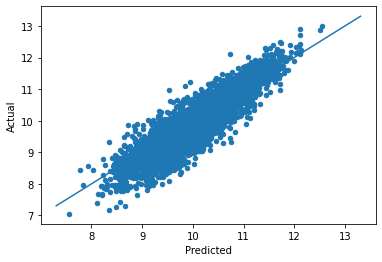

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

zeros_r = cfe.Result(y=(0.+(result.y>0)),z=result.z)
weights = zeros_r.get_predicted_log_expenditures()

# Truncate to make weights live in [0,1]
weights = weights.where((weights<1) + np.isnan(weights),1).where((weights>0) + np.isnan(weights),0)

xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()

# Calculate *expected* predicted expenditures, to make unconditional on being positive
xhat = (weights*result.get_predicted_expenditures())
xsum = xhat.sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xsum)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

Below is the original Assessment of Fit graph

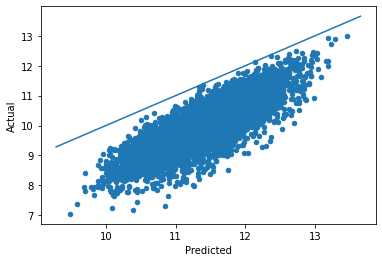

In [30]:
xbar = np.exp(result.y).sum(['m','i']).to_dataframe('xbar').replace(0,np.nan).squeeze()
xhat = result.get_predicted_expenditures().sum(['m','i']).to_dataframe('xhat').replace(0,np.nan).squeeze()

# Make dataframe of actual & predicted
df = pd.DataFrame({'Actual':np.log(xbar),'Predicted':np.log(xhat)})

df.plot.scatter(x='Predicted',y='Actual')

# Add 45 degree line
v = plt.axis()
vmin = np.max([v[0],v[2]])
vmax = np.max([v[1],v[3]])
plt.plot([vmin,vmax],[vmin,vmax])

### Step 5: Get predicted quantities



Now divide predicted expenditures by predicted prices to get predicted
quantities, and put back into a dataframe.



In [10]:
qhat = xhat/phat.to_xarray().to_array('i')

qhat = qhat.to_dataframe('q').unstack('i')

qhat.columns = qhat.columns.droplevel(0)

qhat

i                         beans dry  beans fresh      beef     bread  \
j                 t    m                                               
1013000201        2005 1   0.864958     0.108942  0.800342  0.602130   
                  2010 1   1.274374     0.160353  0.956663       NaN   
                  2011 1   0.709323     0.096690  0.431766  0.228675   
1013000202        2005 1        NaN          NaN       NaN       NaN   
                  2010 1        NaN          NaN       NaN       NaN   
...                             ...          ...       ...       ...   
3030230010040204  2010 1        NaN          NaN       NaN       NaN   
                  2011 1        NaN          NaN       NaN       NaN   
30211230006050302 2005 1        NaN          NaN       NaN       NaN   
                  2010 1        NaN          NaN       NaN       NaN   
                  2011 1        NaN          NaN       NaN       NaN   

i                         cabbages  cassava dry/flour  cassava fresh  chicken  \
j                 t    m                                                        
1013000201        2005 1       NaN           0.518964            NaN      NaN   
                  2010 1       NaN           1.112252            NaN      NaN   
                  2011 1       NaN           0.424878       0.857379      NaN   
1013000202        2005 1       NaN                NaN            NaN      NaN   
                  2010 1       NaN                NaN            NaN      NaN   
...                            ...                ...            ...      ...   
3030230010040204  2010 1       NaN                NaN            NaN      NaN   
                  2011 1       NaN                NaN            NaN      NaN   
30211230006050302 2005 1       NaN                NaN            NaN      NaN   
                  2010 1       NaN                NaN            NaN      NaN   
                  2011 1       NaN                NaN            NaN      NaN   

i                           coffee  cooking oil  ...  other vegetables  \
j                 t    m                         ...                     
1013000201        2005 1  0.117269          NaN  ...          0.396573   
                  2010 1       NaN          NaN  ...          0.450058   
                  2011 1       NaN          NaN  ...          0.077671   
1013000202        2005 1       NaN          NaN  ...               NaN   
                  2010 1       NaN          NaN  ...               NaN   
...                            ...          ...  ...               ...   
3030230010040204  2010 1       NaN          NaN  ...               NaN   
                  2011 1       NaN          NaN  ...               NaN   
30211230006050302 2005 1       NaN          NaN  ...               NaN   
                  2010 1       NaN          NaN  ...               NaN   
                  2011 1       NaN          NaN  ...               NaN   

i                         passion fruits      rice      salt  soda     sugar  \
j                 t    m                                                       
1013000201        2005 1        0.273154  0.755975  0.257980   NaN  1.218235   
                  2010 1        0.337528  1.089641  0.329199   NaN  1.420750   
                  2011 1        0.115185  0.447787  0.199642   NaN  0.635887   
1013000202        2005 1             NaN       NaN       NaN   NaN       NaN   
                  2010 1             NaN       NaN       NaN   NaN       NaN   
...                                  ...       ...       ...   ...       ...   
3030230010040204  2010 1             NaN       NaN       NaN   NaN       NaN   
                  2011 1             NaN       NaN       NaN   NaN       NaN   
30211230006050302 2005 1             NaN       NaN       NaN   NaN       NaN   
                  2010 1             NaN       NaN       NaN   NaN       NaN   
                  2011 1             NaN       NaN       NaN   NaN       NaN   

i    

### Step 6: Map predicted quantities into nutrients



May need some work to clean up the FCT, and create food names/indices
corresponding to the `i` index in `qhat`.



In [11]:
print(pd.Series(xhat.coords['i']).to_markdown())

|    | 0                                  |
|---:|:-----------------------------------|
|  0 | beans dry                          |
|  1 | beans fresh                        |
|  2 | beef                               |
|  3 | bread                              |
|  4 | cabbages                           |
|  5 | cassava dry/flour                  |
|  6 | cassava fresh                      |
|  7 | chicken                            |
|  8 | coffee                             |
|  9 | cooking oil                        |
| 10 | dodo                               |
| 11 | dry/smoked fish                    |
| 12 | eggs                               |
| 13 | expenditure in restaurants on food |
| 14 | fresh fish                         |
| 15 | fresh milk                         |
| 16 | goat meat                          |
| 17 | ground nuts pounded                |
| 18 | irish potatoes                     |
| 19 | maize cobs                         |
| 20 | maize flour              

In [12]:
fct_codes #Pasting here again for reference

,food_descriptions,food_code
0,Matooke(cluster),5001.0
1,Matooke(others),5001.0
2,avocado,29110.0
3,beans dry,6009.0
4,beans fresh,6002.0
...,...,...
57,sweet potatoes dry,3018.0
58,sweet potatoes fresh,3001.0
59,tea,NaN
60,tomatoes,29063.0


In [13]:
# Dictionary mapping index i to fct codes
i_to_fct = pd.read_csv('uganda_fct_data.csv').dropna().set_index('food_descriptions').squeeze().to_dict() #needs to be from uganda fct

i_to_fct = {k:int(v) for k,v in i_to_fct.items()}

# Create version of qhat with fct ids for labels
myq = qhat.rename(columns=i_to_fct)
keep_columns = myq.columns.intersection(i_to_fct.values())
myq = myq[keep_columns]

# Drop goods with no obs, households with no goods
myq = myq.dropna(how='all',axis=1).dropna(how='all')

myfct=fct[fct['food_code'].isin(myq.columns)].drop(columns={'food_description', 'food_state', 'food_state_code',
                                                            'fct_source', 'fct_source_code', 'fct_source_descr',
                                                            'water_source_descr', 'retention_source', 'retention_source_code',
                                                            'retention_source_descr', 'food_group', 'food_group_code'})
# Create version of fct with just foods in myq
# Need to drop columns in fct that aren't nutrients
# Drop columns which aren't nutrients

In [31]:
myq

i                           6009      6002      11001     1305      2020   \
j                t    m                                                     
1013000201       2005 1  0.864958  0.108942  0.800342  0.602130  0.518964   
                 2010 1  1.274374  0.160353  0.956663       NaN  1.112252   
                 2011 1  0.709323  0.096690  0.431766  0.228675  0.424878   
1013000202       2011 1  0.599940  0.089360  0.326716  0.196362  0.376393   
1013000204       2010 1  0.827965  0.150991  0.633639       NaN  0.797782   
...                           ...       ...       ...       ...       ...   
241030038080403  2011 1  0.365843  0.042999  0.208584  0.104931  0.255052   
301101000102050  2011 1  0.743433  0.121154  0.559555  0.388360  0.386405   
3010730012030203 2011 1  0.794144  0.179945  0.701872  0.498966  0.375693   
3010730016100203 2011 1  0.391873  0.070892  0.286533  0.172975  0.239822   
3010830020020503 2011 1  0.594036  0.130037  0.418999  0.279525  0.365882   

i                           2001      14006     14001     9001      12101  \
j                t    m                                                     
1013000201       2005 1       NaN  0.383530  0.321748       NaN  0.079613   
                 2010 1       NaN  0.320220  0.466409       NaN  0.096914   
                 2011 1  0.857379  0.190893  0.177895  1.774336  0.034215   
1013000202       2011 1  0.669360  0.182784  0.166457  1.889060  0.041695   
1013000204       2010 1       NaN  0.246126  0.381726       NaN  0.109408   
...                           ...       ...       ...       ...       ...   
241030038080403  2011 1  0.391815  0.115921  0.103375  1.054429  0.029172   
301101000102050  2011 1  0.819249  0.262554  0.283442  3.599935  0.070824   
3010730012030203 2011 1  0.769135  0.308975  0.361449  5.142068  0.104860   
3010730016100203 2011 1  0.415988  0.127555  0.144311  1.601038  0.036412   
3010830020020503 2011 1  0.606009  0.182994  0.205124  2.647587  0.054063   

i                        ...     1021      1041      30025     1104   \
j                t    m  ...                                           
1013000201       2005 1  ...  0.096761  1.238646  0.054286  0.096485   
                 2010 1  ...       NaN  1.666310       NaN  0.110453   
                 2011 1  ...  0.106606  0.949329       NaN  0.073951   
1013000202       2011 1  ...  0.091786  0.747438       NaN  0.070241   
1013000204       2010 1  ...       NaN  1.130105       NaN  0.123609   
...                      ...       ...       ...       ...       ...   
241030038080403  2011 1  ...  0.073340  0.446862       NaN  0.051846   
301101000102050  2011 1  ...  0.162173  0.944752       NaN  0.107419   
3010730012030203 2011 1  ...  0.238433  1.135910       NaN  0.153476   
3010730016100203 2011 1  ...  0.091657  0.505037       NaN  0.072666   
3010830020020503 2011 1  ...  0.118981  0.757954       NaN  0.108343   

i                           29051     30012     1201      27090     5011   \
j                t    m                                                     
1013000201       2005 1  0.477279  0.273154  0.755975  1.218235       NaN   
                 2010 1  0.535480  0.337528  1.089641  1.420750       NaN   
                 2011 1  0.276295  0.115185  0.447787  0.635887  0.055032   
1013000202       2011 1  0.243235  0.086916  0.346449  0.549827  0.051714   
1013000204       2010 1  0.389844  0.214204  0.697180  1.124210       NaN   
...                           ...       ...       ...       ...       ...   
241030038080403  2011 1  0.157460  0.041187  0.205208  0.287784  0.025030   
301101000102050  2011 1  0.384684  0.178490  0.593109  0.759985  0.105210   
3010730012030203 2011 1  0.463658  0.238217  0.641684  1.074127  0.128093   
3010730016100203 2011 1  0.200176  0.081536  0.288922  0.379037  0.038578   
3010830020020503 2011 1  0.269273  0.145703  0.411495  0.614419  0.065205   

i                           29063  
j                t   

In [14]:
myfct

,food_code,water_g,dry_matter_g,energy_kcal,protein_g,lipid_total_g,carbohydrate_g,fiber_g,calcium_mg,iron_mg,...,folic_acid_mcg,folate_food_mcg,folate_dfe_mcg,vit_b12_mcg,vit_a_iu,vit_a_rae_mcg,retinol_mcg,alpha_carot_mcg,beta_carot_mcg,beta_crypt_mcg
i,,,,,,,,,,,,,,,,,,,,,
15,1021,57.9,42.1,172,4.4,2.2,34.9,4.0,3,1.3,...,0,12,12,0.00,0,0,0,0,0,0
23,1041,11.3,88.7,369,7.3,1.8,79.2,4.0,3,1.1,...,0,30,30,0.00,3,0,0,0,1,1
29,1104,9.7,90.3,374,10.9,4.2,72.1,9.0,8,3.0,...,0,84,84,0.00,0,0,0,0,0,0
32,1201,12.9,87.1,360,6.6,0.6,79.3,NaN,9,0.8,...,0,9,9,0.00,0,0,0,0,0,0
40,1305,36.4,63.6,266,7.6,3.3,50.6,2.0,151,3.7,...,86,25,171,0.00,0,0,0,0,0,0
58,2001,59.7,40.3,160,1.4,0.3,38.1,2.0,16,0.3,...,0,27,27,0.00,13,1,0,0,8,0
63,2020,NaN,NaN,314,2.6,0.7,76.6,4.0,31,1.9,...,0,36,36,0.00,140,7,0,0,84,0
64,2101,79.3,20.7,77,2.0,0.1,17.5,2.0,12,0.8,...,0,16,16,0.00,2,0,0,0,1,0
120,5011,74.9,25.1,89,1.1,0.3,22.8,3.0,5,0.3,...,0,20,20,0.00,64,3,0,25,26,0


Before this will work, need columns of qhat to match columns of fct.



In [17]:
nutrients = myq@myfct
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household.
# This part still needs fixing

ValueError: matrices are not aligned